In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Load Dataset**

We will use the price in Close column this project

In [2]:
import pandas as pd
dataset = pd.read_csv('/content/gdrive/MyDrive/Sequence Learning Assignments/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
print(dataset.head())

             Open   High    Low  Close    Volume Name
Date                                                 
2006-01-03  82.45  82.55  80.81  82.06  11715200  IBM
2006-01-04  82.20  82.50  81.33  81.95   9840600  IBM
2006-01-05  81.40  82.90  81.00  82.50   7213500  IBM
2006-01-06  83.95  85.03  83.41  84.95   8197400  IBM
2006-01-09  84.10  84.25  83.38  83.73   6858200  IBM


In [3]:
dataset.shape

(3020, 6)

In [4]:
print(type(dataset))
print(type(dataset[:'2016']['Close']))
print(type(dataset[:'2016']['Close'].values))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


# **Import Libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,SimpleRNN
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# **Functions to help visualize and calculate RMSE**

In [6]:
def predictions_plot(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# **Test and Train Dataset**

In [7]:
training_set = dataset[:'2014']['Close'].values.reshape(-1,1)  #taking the values from 'High' column
test_set = dataset['2015':]['Close'].values.reshape(-1,1)
print(training_set.shape, test_set.shape, dataset.shape)
type(training_set), type(dataset)

(2265, 1) (755, 1) (3020, 6)


(numpy.ndarray, pandas.core.frame.DataFrame)

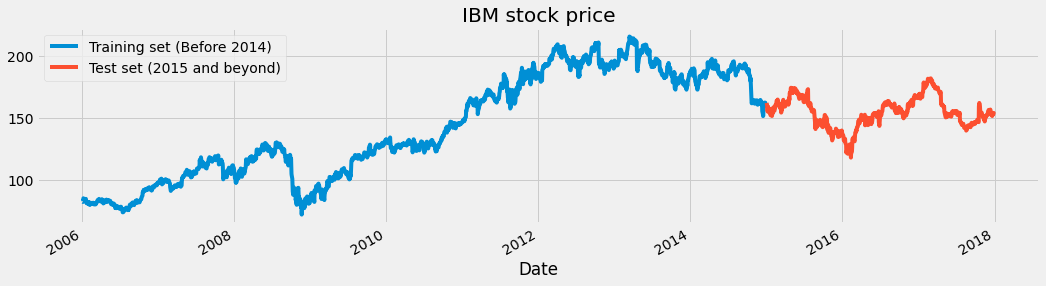

In [8]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["Close"][:'2014'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2015':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2014)','Test set (2015 and beyond)'])
plt.title('IBM stock price')
plt.show()

# **Scale the prices**

In [9]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(2265, 1)

In [10]:
training_set[:10]

array([[82.06],
       [81.95],
       [82.5 ],
       [84.95],
       [83.73],
       [84.07],
       [84.17],
       [83.57],
       [83.17],
       [83.  ]])

In [11]:
training_set_scaled[:10]

array([[0.07163682],
       [0.07087325],
       [0.0746911 ],
       [0.0916979 ],
       [0.08322921],
       [0.08558934],
       [0.08628349],
       [0.08211856],
       [0.07934194],
       [0.07816188]])

# **Pre-process data into required format i.e. each row will be a series of 60 timesteps to predict the proce on 61st timestep**

In [12]:
X_train = []
y_train = []
train_len = len(training_set_scaled)
for i in range(60,train_len):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2205, 60) (2205,)


In [13]:
X_train[0]

array([0.07163682, 0.07087325, 0.0746911 , 0.0916979 , 0.08322921,
       0.08558934, 0.08628349, 0.08211856, 0.07934194, 0.07816188,
       0.08829654, 0.07878662, 0.06677773, 0.06712481, 0.06323754,
       0.06365403, 0.06233514, 0.0644176 , 0.06865195, 0.06636124,
       0.07080383, 0.06587533, 0.05712897, 0.05393586, 0.05629599,
       0.06289046, 0.06011384, 0.06656948, 0.0603915 , 0.06490351,
       0.06323754, 0.06365403, 0.06226572, 0.060808  , 0.06670832,
       0.05872553, 0.05803138, 0.0617104 , 0.05900319, 0.05664307,
       0.05692073, 0.05705956, 0.05733722, 0.05935027, 0.06525059,
       0.0644176 , 0.06823546, 0.07073442, 0.07732889, 0.08079967,
       0.07725948, 0.08024434, 0.08218798, 0.08378453, 0.08822713,
       0.07955019, 0.08066084, 0.0787172 , 0.07420519, 0.07906428])

In [14]:
y_train[0]

0.07955018742190761

**For being used by the RNN/GRU/LSTM layers, we need the shape of X_train to be: [ batch_size, time_steps, Features ]**

**We will use the full data in a single batch, so batch size will be 2205**
**There are 60 time steps**
**At each time step, the price is the feature, which is of 1-dimension. Compare this with a word, which can have higher dimension based on the word embedding chosen**

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(2205, 60, 1)


# **Create the Model**

In [23]:
model = Sequential()

# Layer 1
model.add(SimpleRNN(50, input_shape=(X_train.shape[1],1), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

# Layer 2
model.add(SimpleRNN(50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

# Layer 3
model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

# Layer 4
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))

# The output layer
model.add(Dense(units=1))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 60, 50)            2600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 60, 50)            5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)               

**Train the model**

In [25]:
# Compiling the GRU
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
15/15 [==============================] - 9s 173ms/step - loss: 0.1638
Epoch 2/50
15/15 [==============================] - 3s 176ms/step - loss: 0.0227
Epoch 3/50
15/15 [==============================] - 3s 176ms/step - loss: 0.0153
Epoch 4/50
15/15 [==============================] - 3s 184ms/step - loss: 0.0105
Epoch 5/50
15/15 [==============================] - 3s 197ms/step - loss: 0.0101
Epoch 6/50
15/15 [==============================] - 3s 190ms/step - loss: 0.0081
Epoch 7/50
15/15 [==============================] - 3s 186ms/step - loss: 0.0078
Epoch 8/50
15/15 [==============================] - 3s 173ms/step - loss: 0.0070
Epoch 9/50
15/15 [==============================] - 3s 174ms/step - loss: 0.0067
Epoch 10/50
15/15 [==============================] - 3s 182ms/step - loss: 0.0064
Epoch 11/50
15/15 [==============================] - 3s 181ms/step - loss: 0.0060
Epoch 12/50
15/15 [==============================] - 3s 177ms/step - loss: 0.0059
Epoch 13/50
15/15 [======

**Test the model**

For test_data first record, we need 60 timesteps before that as well

In [26]:
dataset_total = dataset["Close"]
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values ## last 60 values of train_data + all values of test_data
print(len(dataset_total), len(test_set))
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs  = sc.transform(inputs)

3020 755
(815,)
(815, 1)


In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test = np.expand_dims(X_test, 2)
print(X_test.shape)

(755, 60)
(755, 60, 1)


In [28]:
predicted_stock_price = model.predict(X_test)
print(predicted_stock_price.shape)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

(755, 1)
(755, 1)


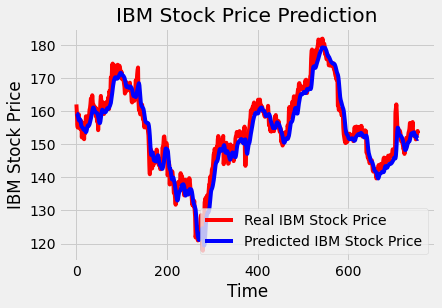

In [29]:
# Visualizing the results for GRU
predictions_plot(test_set,predicted_stock_price)

**Evaluate Model**

In [30]:
rmse_return(test_set,predicted_stock_price)

The root mean squared error is 3.370815961549598.
